Ticker selections
=================

In [1]:
# If you would like to refresh your data, please execute the bellow codes.

import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

from mypo import Loader

DOWNLOAD = False

if DOWNLOAD:
    tickers = pd.read_csv("/app/docs/tutorial/tickers.csv")
    loader = Loader()
    for row in tqdm(tickers.to_dict('record')):
        loader.get(row['Ticker'], expense_ratio=row['ExpenseRatio'] * 0.01)
    loader.save('/app/docs/tutorial/all.bin')

In [2]:
loader = Loader.load('/app/docs/tutorial/all.bin')
loader = loader.since(datetime(2005, 1, 1))
market = loader.get_market()

In [3]:
tickers = market.get_tickers()
tickers.remove('SHY')
tickers.remove('AGG')
market = market.filter(tickers)

In [4]:
pd.set_option('display.max_rows', 200)

summary = loader.summary()
summary = summary.sort_index()
summary

,established,names,total_assets,volume,expense_ratio
AGG,2003-09-29,iShares Core U.S. Aggregate Bond ETF,85938724864,6466483,0.0005
BBH,1999-11-23,VanEck Vectors Biotech ETF,495472128,6928,0.0035
DIA,1998-01-20,SPDR Dow Jones Industrial Average ETF Trust,25793642496,4995800,0.0016
DVY,2003-11-07,iShares Select Dividend ETF,15882481664,1065285,0.0039
EEM,2003-04-14,iShares MSCI Emerging Markets ETF,29338421248,65868433,0.0070
EFA,2001-08-27,iShares MSCI EAFE ETF,53298008064,24144216,0.0032
EPP,2001-10-26,iShares MSCI Pacific ex Japan ETF,2290522112,271300,0.0048
EWG,1996-03-18,iShares MSCI Germany ETF,2596413952,3059500,0.0051
EWJ,1996-03-18,iShares MSCI Japan ETF,13236024320,6636166,0.0051
EWM,1996-03-18,iShares MSCI Malaysia ETF,380267392,300166,0.0051


In [5]:
market.get_summary().sort_index()

,daily return,variance,sharp ratio,expense ratio
BBH,0.000651,0.000201,3.243386,0.0035
DIA,0.000442,0.000143,3.100646,0.0016
DVY,0.000377,0.000160,2.361359,0.0039
EEM,0.000476,0.000351,1.355455,0.0070
EFA,0.000309,0.000197,1.570381,0.0032
EPP,0.000425,0.000261,1.626070,0.0048
EWG,0.000383,0.000269,1.427280,0.0051
EWJ,0.000265,0.000174,1.518079,0.0051
EWM,0.000283,0.000175,1.615122,0.0051
EWS,0.000393,0.000235,1.671178,0.0051


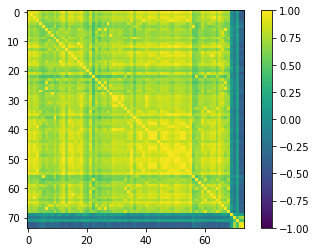

,VTI,SPTM,VIS,IXN,IYR,VPU,VDE,FXI,EWZ,VDC,...,XLV,DIA,EEM,XLE,PPH,GLD,TIP,LQD,TLT,IEF
VTI,1.000000,0.875482,0.938206,0.909863,0.786737,0.717966,0.785157,0.737461,0.727394,0.838075,...,0.831363,0.966363,0.848465,0.783709,0.788244,0.049922,-0.172429,0.140007,-0.415551,-0.407574
SPTM,0.875482,1.000000,0.857539,0.815245,0.741859,0.609432,0.676777,0.658751,0.630179,0.740941,...,0.705979,0.845721,0.741687,0.685172,0.680704,0.022329,-0.185696,0.043660,-0.396070,-0.395306
VIS,0.938206,0.857539,1.000000,0.836061,0.755845,0.651241,0.761983,0.689812,0.691982,0.771825,...,0.744260,0.924980,0.794401,0.757034,0.707186,0.029587,-0.182244,0.109723,-0.425476,-0.419461
IXN,0.909863,0.815245,0.836061,1.000000,0.672716,0.595405,0.662613,0.709569,0.677147,0.733284,...,0.730146,0.871600,0.809465,0.658537,0.689146,0.054102,-0.160413,0.138347,-0.364510,-0.362002
IYR,0.786737,0.741859,0.755845,0.672716,1.000000,0.634718,0.569118,0.596207,0.570218,0.672800,...,0.580295,0.745535,0.685704,0.568377,0.557571,0.048909,-0.101207,0.135970,-0.241348,-0.240959
VPU,0.717966,0.609432,0.651241,0.595405,0.634718,1.000000,0.586600,0.516139,0.561677,0.758336,...,0.635055,0.719169,0.617117,0.593060,0.602682,0.102011,-0.054383,0.216361,-0.209599,-0.191506
VDE,0.785157,0.676777,0.761983,0.662613,0.569118,0.586600,1.000000,0.620513,0.693814,0.596870,...,0.583858,0.765567,0.730213,0.990476,0.575267,0.160947,-0.076502,0.112469,-0.363996,-0.341670
FXI,0.737461,0.658751,0.689812,0.709569,0.596207,0.516139,0.620513,1.000000,0.687574,0.592935,...,0.569668,0.714326,0.894271,0.622189,0.554745,0.093298,-0.158915,0.117727,-0.318574,-0.342129
EWZ,0.727394,0.630179,0.691982,0.677147,0.570218,0.561677,0.693814,0.687574,1.000000,0.599750,...,0.547075,0.704566,0.835251,0.692098,0.536011,0.179145,-0.054472,0.170463,-0.288824,-0.276361
VDC,0.838075,0.740941,0.771825,0.733284,0.672800,0.758336,0.596870,0.592935,0.599750,1.000000,...,0.774610,0.851901,0.692441,0.601227,0.739180,0.026346,-0.160758,0.127522,-0.322620,-0.310257


In [6]:
import matplotlib.pyplot as plt
from mypo import clustering_tickers, evaluate_combinations

CLUSTERS = 3
cluster = clustering_tickers(market, n=CLUSTERS)
corr = market.get_rate_of_change()[cluster.index].corr()

plt.figure()
plt.imshow(corr,interpolation='nearest',vmin=-1,vmax=1,cmap='viridis')
plt.colorbar()
plt.show()

corr

In [7]:
from mypo import split_k_folds, select_by_regression
from mypo.optimizer import MaximumDiversificationOptimizer
from mypo.rebalancer import MonthlyRebalancer
from mypo import Runner

folds = split_k_folds(market, 4, 200)


100%|██████████| 979/979 [00:13<00:00, 72.14it/s]


                     tickers  yearly total return  max draw down  \
0  [IYR, GLD, SPY, TIP, TLT]             1.105925       0.869278   

   max draw down span  
0                 214  


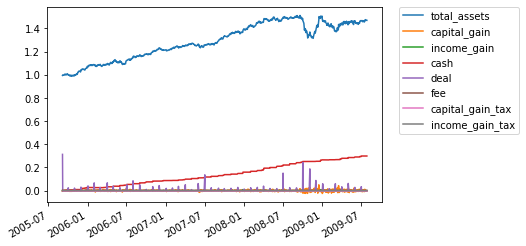

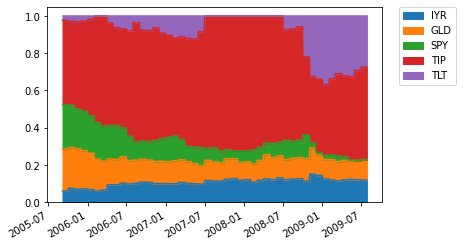

100%|██████████| 979/979 [00:13<00:00, 71.97it/s]


                     tickers  yearly total return  max draw down  \
0  [IYR, GLD, SPY, TIP, TLT]             1.140557       0.954534   

   max draw down span  
0                  77  


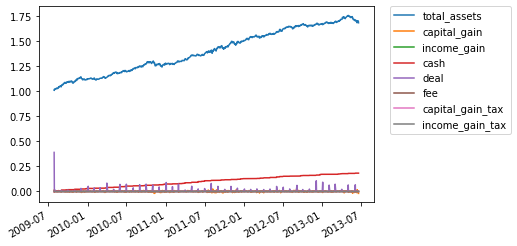

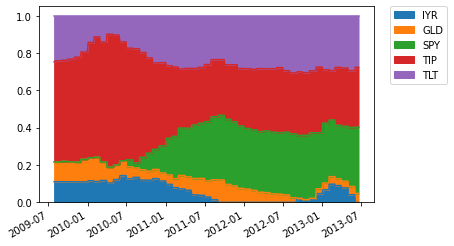

100%|██████████| 979/979 [00:13<00:00, 72.44it/s]


                     tickers  yearly total return  max draw down  \
0  [IYR, GLD, SPY, TIP, TLT]             1.073006       0.945545   

   max draw down span  
0                 221  


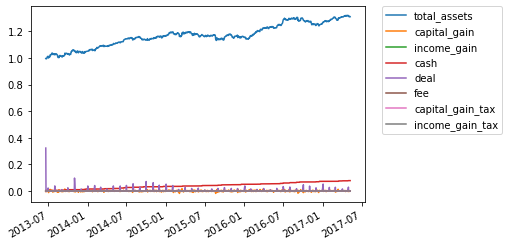

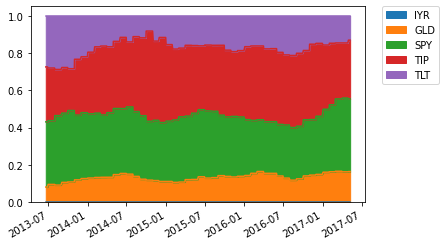

100%|██████████| 979/979 [00:13<00:00, 71.98it/s]


                     tickers  yearly total return  max draw down  \
0  [IYR, GLD, SPY, TIP, TLT]             1.088162       0.866449   

   max draw down span  
0                 253  


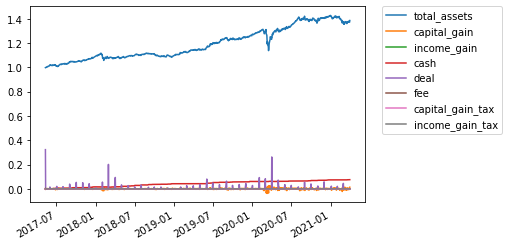

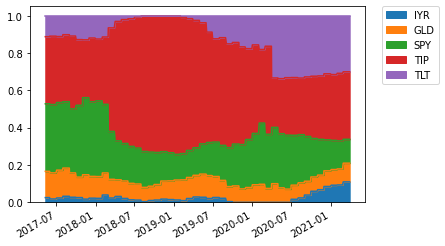

In [8]:
for i in range(len(folds)):
    selected_tickers = ['SPY', 'IYR', 'TLT', 'TIP', 'GLD']
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()


100%|██████████| 979/979 [00:11<00:00, 84.01it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [EWZ, IEF, GLD]             1.141435       0.899624                 145


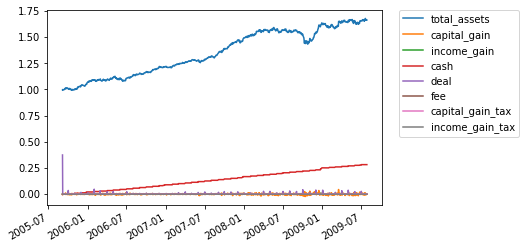

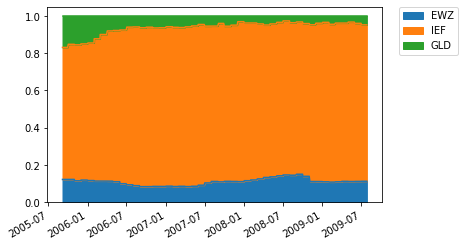

100%|██████████| 979/979 [00:11<00:00, 86.03it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [TIP, RWR, IEF]             1.117264       0.939085                 115


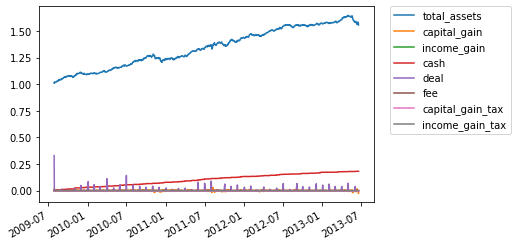

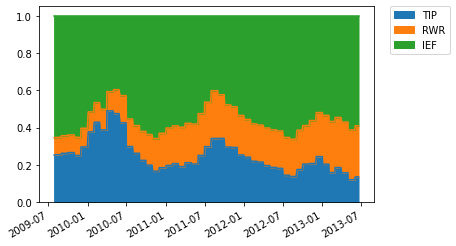

100%|██████████| 979/979 [00:11<00:00, 86.47it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [IEF, FEZ, GLD]             1.054314       0.938145                 229


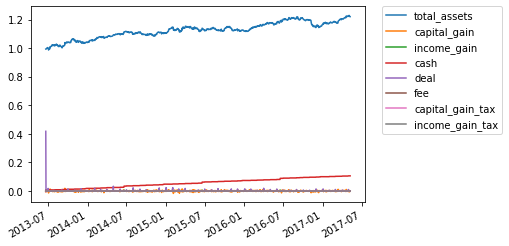

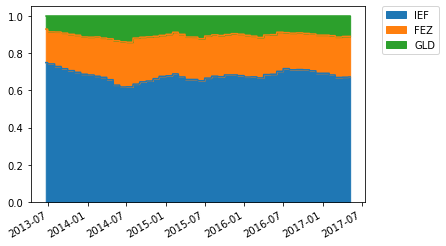

100%|██████████| 979/979 [00:11<00:00, 84.05it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [XLF, IEF, GLD]             1.065099       0.908282                 233


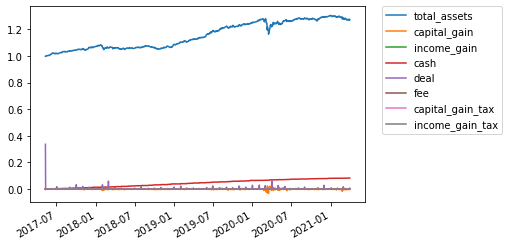

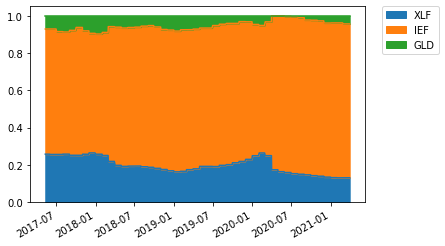

In [9]:
for i in range(len(folds)):
    evaluates = evaluate_combinations(folds[i].get_train(), cluster, optimizer=MaximumDiversificationOptimizer(), verbose=True)
    fold = folds[i].filter((list(evaluates['combinations'])[0]))
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

100%|██████████| 979/979 [00:11<00:00, 85.00it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [EWZ, TIP, TLT]              1.13314       0.858305                 144


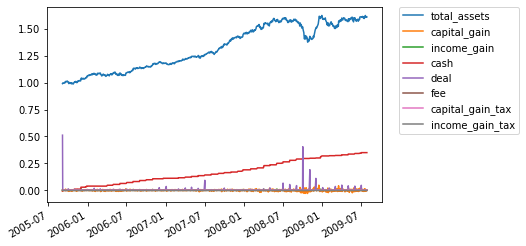

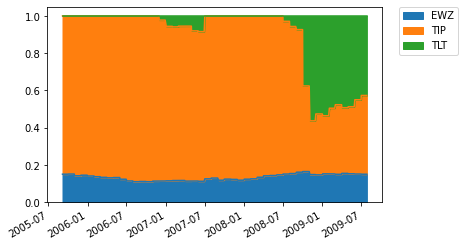

100%|██████████| 979/979 [00:11<00:00, 88.67it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [LQD, EWZ, IEF]             1.075273       0.935465                 140


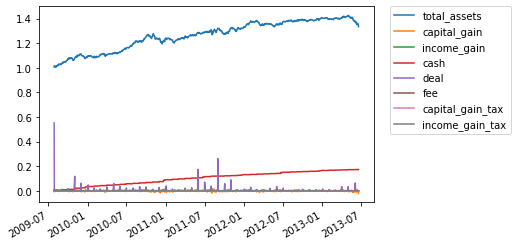

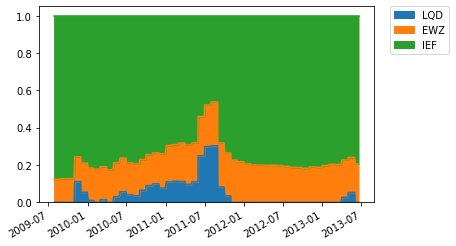

100%|██████████| 979/979 [00:11<00:00, 87.27it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [LQD, IEF, BBH]             1.069677       0.937317                 244


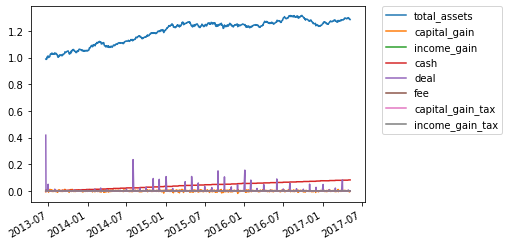

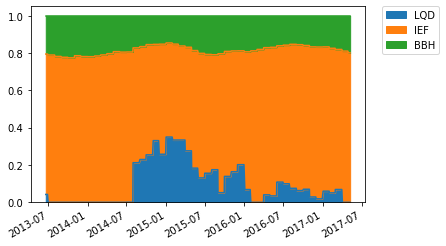

100%|██████████| 979/979 [00:11<00:00, 85.78it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [TIP, IEF, IXN]             1.082781       0.918857                 111


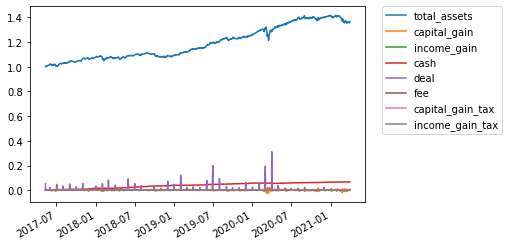

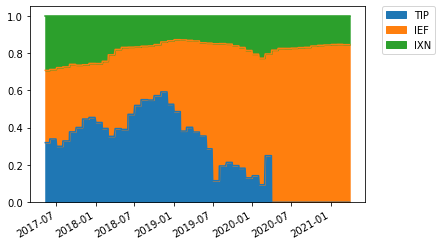

In [10]:
for i in range(len(folds)):
    df = pd.concat([folds[i].get_train().get_summary(), cluster], axis=1)
    selected_tickers = list(df.groupby('class').idxmax().reset_index(drop=True)['daily return'])
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

100%|██████████| 979/979 [00:12<00:00, 80.67it/s]


                tickers  yearly total return  max draw down  \
0  [EWJ, SPY, TLT, ILF]             1.131507       0.875359   

   max draw down span  
0                 144  


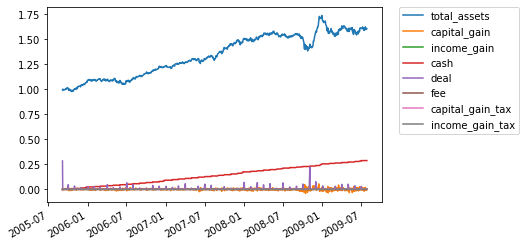

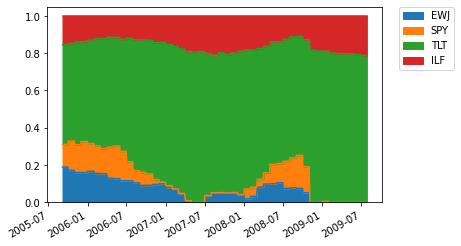

100%|██████████| 979/979 [00:10<00:00, 96.88it/s]


      tickers  yearly total return  max draw down  max draw down span
0  [SPY, IEF]             1.116367       0.956833                 102


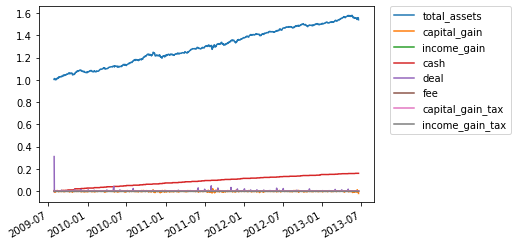

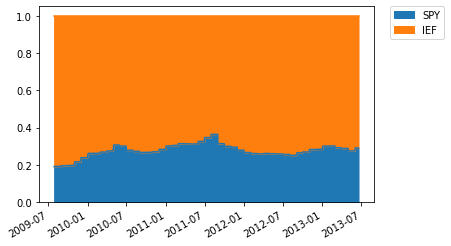

100%|██████████| 979/979 [00:09<00:00, 98.14it/s]


      tickers  yearly total return  max draw down  max draw down span
0  [SPY, IEF]             1.082453       0.963886                 120


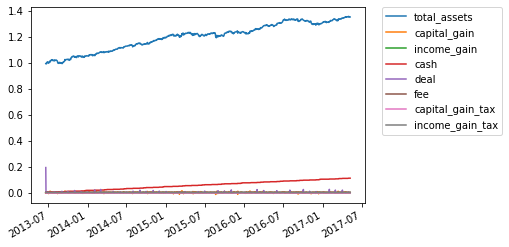

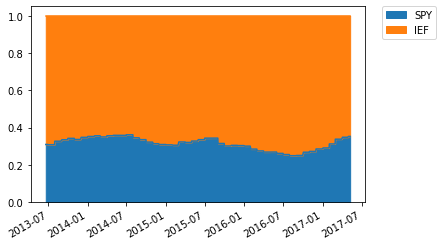

100%|██████████| 979/979 [00:11<00:00, 87.54it/s]


           tickers  yearly total return  max draw down  max draw down span
0  [SPY, TIP, EWY]             1.089501       0.870283                 145


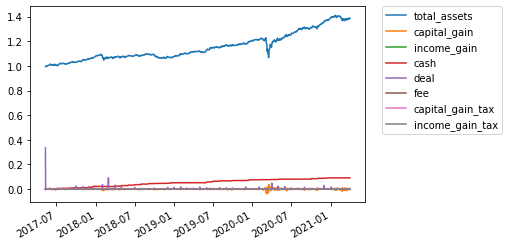

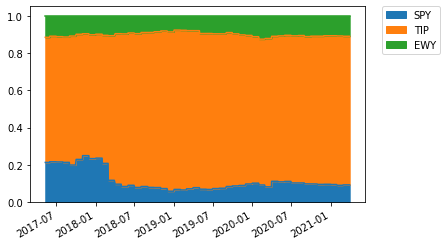

In [11]:
for i in range(len(folds)):
    selected_tickers = select_by_regression(folds[i].get_train(), threshold=0.8)
    fold = folds[i].filter(selected_tickers)
    optimizer = MaximumDiversificationOptimizer()
    runner = Runner(
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
    )

    runner.run(
        fold=fold,
        verbose=True
    )
    report = runner.report()
    print(report.summary())
    ax = report.history().plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    ax = report.history_weights().plot.area(stacked=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()